# Learning the task prior

This notebook was used to generate the figure for "Learning the task prior..." (Appendix Fig. 20). 

Unlike the models considered in the main body, the models here are trained on a dataset generated for a *finite set of tasks* $\mathbf{t}$ of size $M$, where $\log_2 M = 0 .. 20$.  

This notebook compares the average prediction of the resulting models over time to the predictions made using either the "O prediction" ($x_k \mapsto 0_D$) or the "task-average" prediction ($x_k \mapsto \bar{\mathbf{t}}\cdot x_k$, where $\bar{\mathbf{t}}= M^{-1}\sum_{m=1}^M \mathbf{t}_m$) for models trained on finite datasets, to show the model ends up closer to the task average than the O prediction. 

In [1]:
import os
from dotenv import load_dotenv

load_dotenv();

In [17]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
from copy import deepcopy 
from icl.constants import DATA, DEVICE

from icl.analysis.utils import get_unique_run
from devinterp.mechinterp.hooks import hook

from icl.constants import FIGURES, SWEEPS
from icl.figures.plotting import WIDTH, HEIGHT, FULL_WIDTH, FULL_HEIGHT
from icl.monitoring import stdlogger

In [ ]:
runs = [get_unique_run(
    SWEEPS / "training-runs/archive/small-L-2.yaml", 
    task_config={"num_tasks": 2 ** m, "num_layers": 2},
    optimizer_config={"lr": 0.01}
) for m in range(21)]

In [ ]:
from icl.train import Run

def get_task_prior(run: Run):
    tasks = run.pretrain_dist.task_distribution.tasks
    return tasks.mean(dim=0).cpu().numpy()

task_priors = [get_task_prior(run) for run in runs]

# Load checkpoints

In [7]:
num_checkpoints = len(runs[0].checkpointer)
all_models = []

if not os.path.exists(DATA / "m-finite-models.pkl"):
    
    stdlogger.info("Retrieving models from bucket")
    pbar = tqdm.tqdm(runs)
    for i, run in enumerate(pbar):
        models = []

        for j, checkpoint in enumerate(run.checkpointer):
            m = deepcopy(run.model)
            m.load_state_dict(checkpoint["model"])
            models.append(m)

            pbar.set_description(f"({i}) {j}/{num_checkpoints}")

        all_models.append(models)

    stdlogger.info("Saving models to disk")
    with open(DATA / 'm-finite-models.pkl', 'wb') as f:
        torch.save(all_models, f)

else:
    stdlogger.info("Loading models from disk")
    with open(DATA / 'm-finite-models.pkl', 'rb') as f:
        all_models = torch.load(f)

(20) 95/96: 100%|██████████| 21/21 [13:52<00:00, 39.67s/it]


# Compare to 0 prediction and task midpoint

In [14]:
from icl.constants import DEVICE
from icl.tasks import apply_transformations

task_midpoint_evals = []

pbar = tqdm.tqdm(zip(runs, all_models, task_priors), total=len(runs))
steps = list(sorted(run.checkpointer.file_ids))

for i, (run, models, task_prior) in enumerate(pbar):
    xs, ys = run.evaluator.pretrain_xs, run.evaluator.pretrain_ys
    xs, ys = xs.to(DEVICE), ys.to(DEVICE)

    _task_prior = torch.tensor(task_prior).to(DEVICE).reshape(1, -1, 1).repeat(xs.shape[0], 1, 1)
    y_preds_with_taskprior = apply_transformations(_task_prior, xs, 0., DEVICE)

    for j, (step, model) in enumerate(zip(steps, models)):
        y_preds = model(xs, ys)
        y_pred_norms = (y_preds ** 2).sum(dim=1).mean(dim=0).item()
        y_pred_dist_to_prior = ((y_preds - y_preds_with_taskprior) ** 2).sum(dim=1).mean(dim=0).item()

        task_midpoint_evals.append({
            'step': step,
            'm': i,
            "M": 2 ** i,
            'y_pred_norms': y_pred_norms,
            'y_pred_dist_to_prior': y_pred_dist_to_prior,
        })

        pbar.set_description(f"({i}) {j}/{num_checkpoints}")

task_midpoint_evals = pd.DataFrame(task_midpoint_evals)

(20) 95/96: 100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


# Plot figure

<ipython-input-18-2af19b89ecc7>:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(min_ylim, max_ylim)


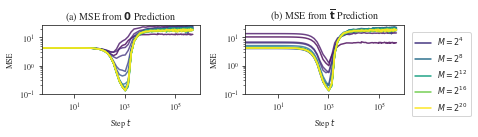

In [18]:
df = task_midpoint_evals.loc[task_midpoint_evals.m > 0]

fig, axes = plt.subplots(1, 2, figsize=(FULL_WIDTH, FULL_HEIGHT))

sns.lineplot(df, x='step', y='y_pred_norms', hue='m', palette='viridis', ax=axes[0], alpha=0.8)
sns.lineplot(df, x='step', y='y_pred_dist_to_prior', hue='m', palette='viridis', ax=axes[1], alpha=0.8)

axes[0].set_title("(a) MSE from $\mathbf{0}$ Prediction")
axes[1].set_title("(b) MSE from $\overline{\mathbf{t}}$ Prediction")

ylims1 = axes[0].get_ylim()
ylims2 = axes[1].get_ylim()

min_ylim = min(ylims1[0], ylims2[0])
max_ylim = max(ylims1[1], ylims2[1])

for ax in axes:
    ax.set_xlabel("Step $t$")
    ax.set_xscale("log")
    ax.set_ylabel("MSE")
    ax.set_yscale("log")
    ax.legend().remove()
    ax.set_ylim(min_ylim, max_ylim)

handles = axes[0].get_legend_handles_labels()[0]
ax.legend(handles=handles, labels=[f"$M = 2^{{{m}}}$" for m in [4, 8, 12, 16, 20]], bbox_to_anchor=(1.05, .9), loc='upper left', borderaxespad=0.)

fig.tight_layout()
fig.savefig(FIGURES / "m-finite/task-prior.pdf", bbox_inches='tight')
plt.show()